In [1]:
# Import the necessary packages and data
from collections import defaultdict
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
sns.set()
path = os.path.expanduser('~/Projects/capstone-two/data/processed/Clean_Harbor_Water_Quality.csv', )
wq_df = pd.read_csv(path, parse_dates=['Sample Date'], index_col=0)

In [2]:
row_counts = wq_df.notnull().sum(axis=1)

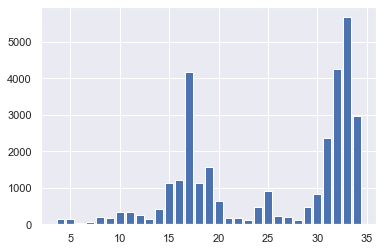

In [3]:
_ = plt.bar(x=row_counts.value_counts().index,
            height=row_counts.value_counts().values)

I want to use only rows with at least 30 columns complete. This is to prevent my data from being overloaded with imputed data.

In [4]:
wq_df['row_sums'] = wq_df.notnull().sum(axis=1)
wq_df[wq_df['row_sums'] < 30]
wq_df = wq_df.drop(columns=['row_sums'])

Next I will fill in blank values

In [5]:
ffill_df = pd.DataFrame()
for site in wq_df['Sampling Location'].unique():
    site_df = wq_df[wq_df['Sampling Location'] == site].sort_values(by='Sample Date')
    site_df = site_df.fillna(method='ffill')
    ffill_df = ffill_df.append(site_df)

In [6]:
final_df = pd.DataFrame()
for site in ffill_df['Sampling Location'].unique():
    site_df = ffill_df[ffill_df['Sampling Location'] == site].sort_values(by='Sample Date')
    site_df = site_df.fillna(method='bfill')
    final_df = final_df.append(site_df)

In [7]:
final_df = final_df.sort_index()
final_df = final_df.reset_index(drop=True)

In [8]:
# Make dummy columns for dry/wet
final_df = pd.get_dummies(final_df, columns=['Weather Condition (Dry or Wet)'])
final_df = final_df.drop(columns=['Weather Condition (Dry or Wet)_D'])

I noticed something weird with the pH values, so I need to fix them.

In [9]:
final_df.nsmallest(10, 'Top PH')['Top PH']

26416    0.33
26585    0.68
27664    1.22
29795    1.22
14190    3.20
14734    4.17
24511    4.75
2949     5.90
2989     5.90
3362     5.90
Name: Top PH, dtype: float64

In [10]:
final_df = final_df.drop(index=[26416, 26585, 27664, 29795, 14190, 14734])

In [11]:
final_df.nsmallest(10, 'Bottom PH')['Bottom PH']

2550     0.00
8123     0.00
10796    0.00
13236    0.00
15495    0.00
19774    0.00
21233    0.00
22427    5.68
14431    6.29
4344     6.44
Name: Bottom PH, dtype: float64

In [12]:
final_df = final_df.drop(index=[2550, 8123, 10796, 13236, 15495, 19774, 21233])

In [13]:
final_df = final_df.reset_index(drop=True)

Different parameters will serve different purposes in my analysis. Some measurements have standard limits that must not be exceeded. The rest of the columns will be potential indicators of poor water quality. I have outlined each column's limit/indicator status below:

- Water Temperature = Indicator

- Salinity = Indicator

- Conductivity = Indicator

- Dissolved Oxygen = 3.0 mg/L

- Light Transparency = Indicator

- Sigma-T = Indicator

- Secchi Depth = Indicator

- pH = 6.0 - 9.5

- Fecal Coliform = 2000 cells/100mL

- Enterococcus = 104 cells/100mL

- Ammonia = 2.0 mg/L

- Ortho-phosphate = 0.20 mg/L

- Kjeldahl Nitrogen = 10.0 mg/L

- Silica = Indicator

- Total Suspended Solids = Indicator

- Chlorophyll a = 30

- Dissolved Organic Carbon = Indicator


In [14]:
# Make functions to 
def check_do(measure):
    if measure < 3.0:
        return 1
    else:
        return 0
    
def check_pH(measure):
    if measure > 9.5 or measure < 6.5:
        return 1
    else:
        return 0
    
def check_fecal(measure):
    if measure > 2000:
        return 1
    else:
        return 0
    
def check_enter(measure):
    if measure > 104:
        return 1
    else:
        return 0
    
def check_nitrate(measure):
    if measure > 10:
        return 1
    else:
        return 0

def check_ammonia(measure):
    if measure > 2:
        return 1
    else:
        return 0
    
def check_phosphate(measure):
    if measure > 0.20:
        return 1
    else:
        return 0
    
def check_chloro(measure):
    if measure > 30:
        return 1
    else:
        return 0
    
# Make a dictionary of each parameter with limits and assign its check function   
check_funcs = {'Top Ammonium (mg/L)':check_ammonia,
               'Top Active Chlorophyll \'A\' (µg/L)':check_chloro,
               'CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L)':check_do,
               'Top Enterococci Bacteria (Cells/100mL)':check_enter,
               'Top Fecal Coliform Bacteria (Cells/100mL)':check_fecal,
               'Top Total Kjeldhal Nitrogen (mg/L)':check_nitrate,
               'Top PH':check_pH,
               'Top Ortho-Phosphorus (mg/L)':check_phosphate
              }


In [15]:
# Create columns that signify whether a measurement is outside limits
fail_col = []
for col, func in check_funcs.items():
    new_col = col + ' Failure'
    fail_col.append(new_col)
    final_df[new_col] = final_df[col].apply(func)


# Correlations
Since a lot of my data have varying scales, I am using Spearman's Correlation rather than Pearson's.

In [16]:
corr_df = final_df.corr('spearman')[['Top Active Chlorophyll \'A\' (µg/L)',
                                     'Top Enterococci Bacteria (Cells/100mL)',
                                     'Top Ortho-Phosphorus (mg/L)']]
corr_df

,Top Active Chlorophyll 'A' (µg/L),Top Enterococci Bacteria (Cells/100mL),Top Ortho-Phosphorus (mg/L)
Top Sample Temperature (ºC),0.208813,-0.162986,0.254670
Bottom Sample Temperature (ºC),0.165309,-0.113950,0.258933
Site Actual Depth (ft),-0.189676,-0.281524,-0.177512
Top Sample Depth(ft),0.005696,-0.198747,0.028308
Bottom Sample Depth (ft),-0.189532,-0.229598,-0.089800
Top Salinity (psu),0.254156,-0.409112,0.078284
Bottom Salinity (psu),0.221215,-0.383709,-0.065614
Top Conductivity (S/m),0.172150,-0.216642,0.209706
Bottom Conductivity (S/m),0.175240,-0.247038,0.133549
"CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L)",0.144373,-0.100835,-0.236221


# Strong Correlations
## Chlorphyll A
- Top pH 0.328890
- Top Silica -0.307083

## Enterococci
- Top Salinity -0.409112
- Bottom Salinity -0.383709
- Fecal Coliform 0.650061
- Top Silica 0.371749
- Latitude 0.301872 (seems flukey so I'm going to ignore)
- Weather Condition 0.337189
- Fecal Coliform Failure 0.412793

## Ortho-phosphorus
- Top pH 0.306060
- Ammonium 0.532703
- Total Kjeldhal Nitrogen 0.410017
- Top Silica 0.327442

# Chlorophyll A

In [17]:
chloro_corr_df = final_df.corr('spearman')['Top Active Chlorophyll \'A\' (µg/L)']

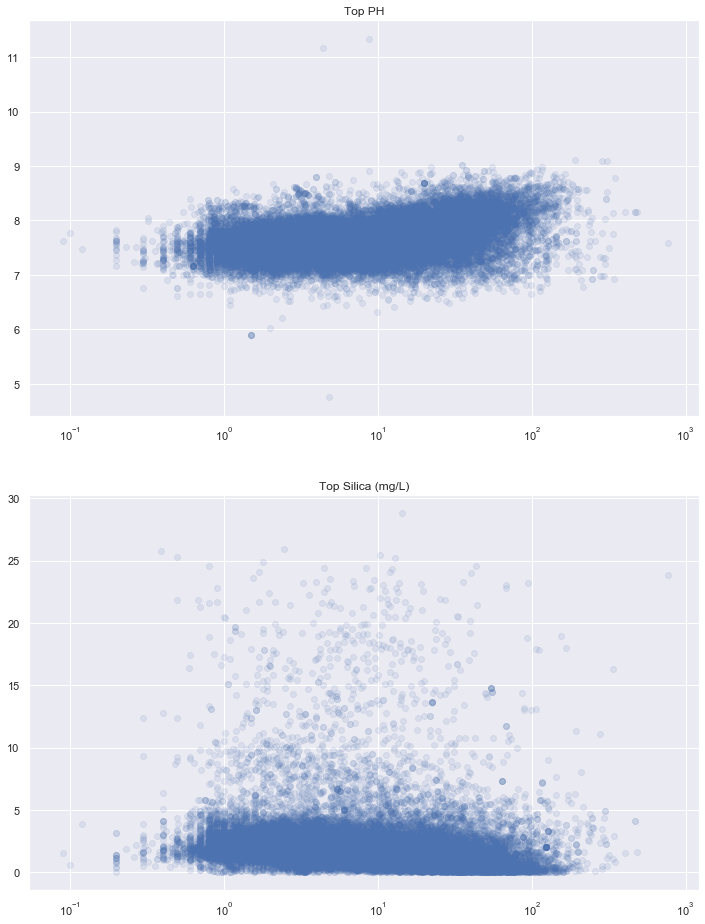

In [18]:
chloro_corr_col = chloro_corr_df[(chloro_corr_df.abs() > 0.3)].index
chloro_corr_col = chloro_corr_col.drop(labels=['Top Active Chlorophyll \'A\' (µg/L)', 
                                               'Top Active Chlorophyll \'A\' (µg/L) Failure'])

sub = 211
_ = plt.figure(figsize=(12,16))
for col in chloro_corr_col:
    _ = plt.subplot(sub)
    _ = plt.scatter(x=final_df['Top Active Chlorophyll \'A\' (µg/L)'],
                    y=final_df[col], alpha=0.1)
    _ = plt.xscale('log')
    _ = plt.title(col)
    sub += 1
        
_ = plt.show()

# Enterococci

In [19]:
ent_corr_df = final_df.corr('spearman')['Top Enterococci Bacteria (Cells/100mL)']
ent_corr_col = ent_corr_df[(ent_corr_df.abs() > 0.3)].index
ent_corr_col = ent_corr_col.drop(labels=['Top Enterococci Bacteria (Cells/100mL)', 
                                         'Top Enterococci Bacteria (Cells/100mL) Failure',
                                         'Lat'])

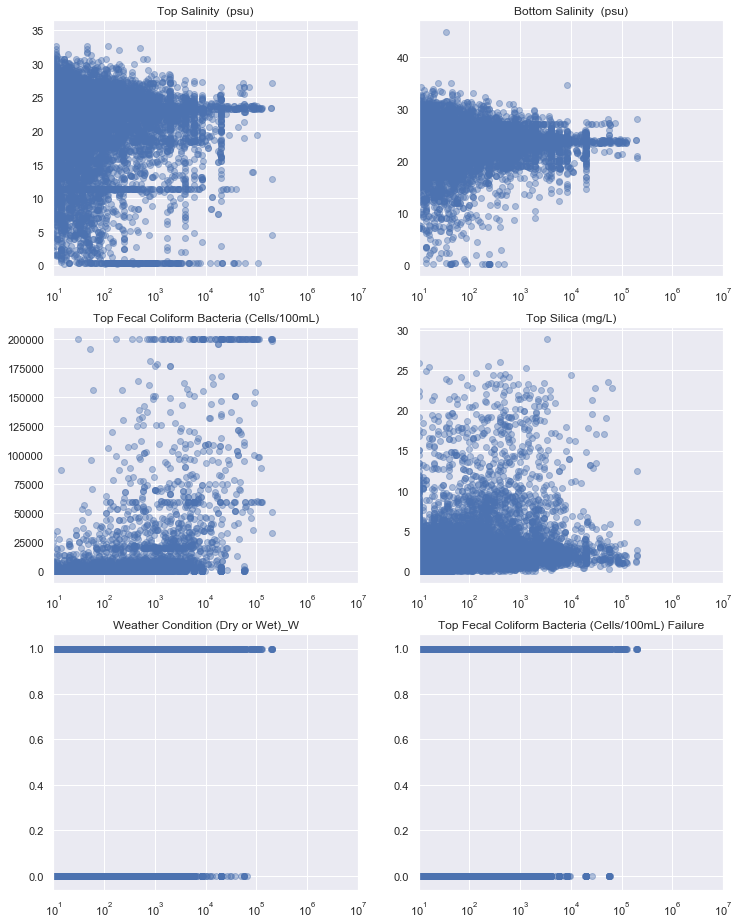

In [20]:
sub = 321
_ = plt.figure(figsize=(12,16))
for col in ent_corr_col:
    _ = plt.subplot(sub)
    _ = plt.scatter(x=final_df['Top Enterococci Bacteria (Cells/100mL)'],
                    y=final_df[col], alpha=0.4)
    _ = plt.xscale('log')
    _ = plt.xlim((10e0, 10e6))
    _ = plt.title(col)
    sub += 1
        
_ = plt.show()


# Ortho-Phosphorus

In [21]:
pho_corr_df = final_df.corr('spearman')['Top Ortho-Phosphorus (mg/L)']
pho_corr_col = pho_corr_df[(pho_corr_df.abs() > 0.3)].index
pho_corr_col = pho_corr_col.drop(labels=['Top Ortho-Phosphorus (mg/L)', 
                                         'Top Ortho-Phosphorus (mg/L) Failure'
                                        ]
                                )                

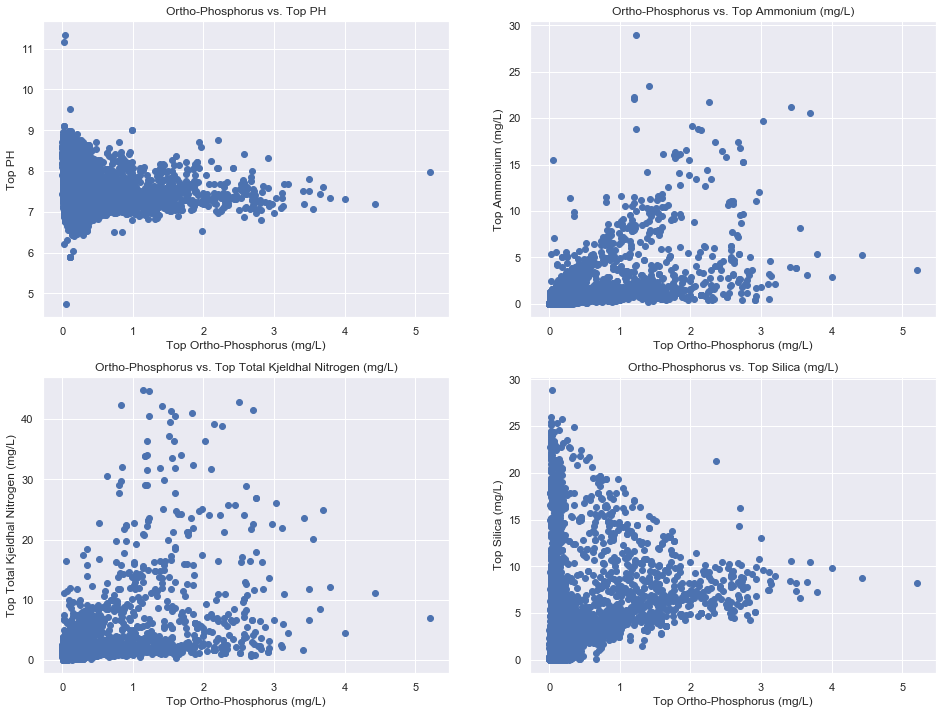

In [22]:
sub = 221
_ = plt.figure(figsize=(16,12))
for col in pho_corr_col:
    if np.dtype(final_df[col]) != object:
        _ = plt.subplot(sub)
        _ = plt.scatter(x=final_df['Top Ortho-Phosphorus (mg/L)'],
                    y=final_df[col])
        _ = plt.title('Ortho-Phosphorus vs. ' + col)
        _ = plt.xlabel('Top Ortho-Phosphorus (mg/L)')
        _ = plt.ylabel(col)
        sub += 1
_ = plt.show()

In [23]:
final_df.loc[:, fail_col].sum()

Top Ammonium (mg/L) Failure                                                             497
Top Active Chlorophyll 'A' (µg/L) Failure                                              5058
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure    1850
Top Enterococci Bacteria (Cells/100mL) Failure                                         4324
Top Fecal Coliform Bacteria (Cells/100mL) Failure                                      2721
Top Total Kjeldhal Nitrogen (mg/L) Failure                                              181
Top PH Failure                                                                           19
Top Ortho-Phosphorus (mg/L) Failure                                                    3559
dtype: int64

Taking a look at the totals for each Failure column, the most common pollutant is Chlorophyll A by a followed by Chlorophyll A and Enterococci. I'm going to investigate these three parameters in greater depth.

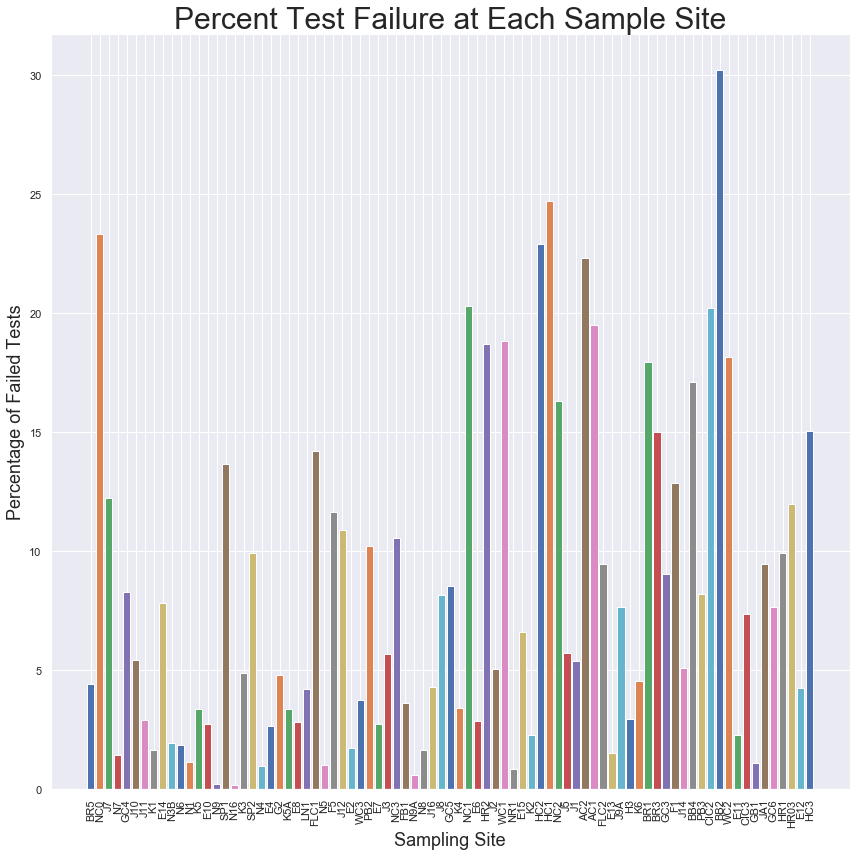

In [24]:
_ = plt.figure(figsize=(12, 12))

for location in final_df['Sampling Location'].unique():
    num = final_df[final_df['Sampling Location'] == location].loc[:, fail_col].sum().sum()
    den = final_df[final_df['Sampling Location'] == location].shape[0]
    ht = num / den / 8 * 100
    _ = plt.bar(x = location, 
            height = ht)

_ = plt.title('Percent Test Failure at Each Sample Site',
             fontsize=30)
_ = plt.xlabel('Sampling Site', fontsize=18)
_ = plt.ylabel('Percentage of Failed Tests', fontsize=18)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.show()

I want to see if there are significant differences between samples that fail to meet EPA limits.

- The null hypothesis is that there is no significant difference between the mean values for samples that exceed limits and those that don't.
- The alternate hypothesis is that there is a significant difference between the means of both.

My original $\alpha$ value is 0.05, but since I am testing 39 columns simultaneously, I need to perform a Bonferroni correction on my $\alpha$ by dividing 0.05 by 39. After doing so, my new $\alpha$ = 0.00128.

I will be performing this for Top Enterococci Bacteria, Top Active Chlorophyll A, and Top Ortho-Phosphate.

# Compare failures to non failed starting with Enterococci

In [25]:
failed_e = final_df[final_df['Top Enterococci Bacteria (Cells/100mL) Failure'] == 1]
passed_e = final_df[final_df['Top Enterococci Bacteria (Cells/100mL) Failure'] == 0]

failed_e = failed_e.drop(columns=['Sampling Location', 
                                  'Sample Date', 
                                  'Sample Time', 
                                  'Lat', 'Long'])
passed_e = passed_e.drop(columns=['Sampling Location', 
                                  'Sample Date', 
                                  'Sample Time', 
                                  'Lat', 'Long'])

In [26]:
from statsmodels.stats import weightstats

h_o = zip(failed_e.columns, weightstats.ztest(passed_e, failed_e)[1])

def sig(value, alpha):
    if value < alpha:
        return 'Significant'
    else:
        return 'Not significant'
    
for i in list(h_o):
    if sig(i[1], 0.00128) == 'Significant':
        print(i[0])

Site Actual Depth (ft)
Top PH
Top Fecal Coliform Bacteria (Cells/100mL)
Top Enterococci Bacteria (Cells/100mL)
Top Ammonium (mg/L)
Top Total Kjeldhal Nitrogen (mg/L)
Top Silica (mg/L)
Top Total Suspended Solid (mg/L)
Top Dissolved Organic Carbon (mg/L)
Weather Condition (Dry or Wet)_W
Top Ammonium (mg/L) Failure
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure
Top Enterococci Bacteria (Cells/100mL) Failure
Top Fecal Coliform Bacteria (Cells/100mL) Failure
Top PH Failure
Top Ortho-Phosphorus (mg/L) Failure


C:\Users\Drew\Anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:655: RuntimeWarning: divide by zero encountered in true_divide
  zstat = (value1 - value2 - diff) / std_diff
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


# Chlorophyll A Differences

In [27]:
failed_c = final_df[final_df['Top Active Chlorophyll \'A\' (µg/L) Failure'] == 1]
passed_c = final_df[final_df['Top Active Chlorophyll \'A\' (µg/L) Failure'] == 0]

failed_c = failed_c.drop(columns=['Sampling Location', 
                                  'Sample Date', 
                                  'Sample Time', 
                                  'Lat', 'Long'])
passed_c = passed_c.drop(columns=['Sampling Location', 
                                  'Sample Date', 
                                  'Sample Time', 
                                  'Lat', 'Long'])

In [28]:
from statsmodels.stats import weightstats

h_o = zip(failed_c.columns, weightstats.ztest(passed_c, failed_c)[1])

def sig(value, alpha):
    if value < alpha:
        return 'Significant'
    else:
        return 'Not significant'
    
for i in list(h_o):
    if sig(i[1], 0.00128) == 'Significant':
        print(i[0])

Site Actual Depth (ft)
Top PH
Top Ammonium (mg/L)
Top Ortho-Phosphorus (mg/L)
Top Total Kjeldhal Nitrogen (mg/L)
Top Silica (mg/L)
Top Total Suspended Solid (mg/L)
Top Active Chlorophyll 'A' (µg/L)
Top Dissolved Organic Carbon (mg/L)
Weather Condition (Dry or Wet)_W
Top Active Chlorophyll 'A' (µg/L) Failure
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure
Top Ortho-Phosphorus (mg/L) Failure


C:\Users\Drew\Anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:655: RuntimeWarning: divide by zero encountered in true_divide
  zstat = (value1 - value2 - diff) / std_diff
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


# Ortho-Phosphate Differences

In [29]:
failed_p = final_df[final_df['Top Enterococci Bacteria (Cells/100mL) Failure'] == 1]
passed_p = final_df[final_df['Top Enterococci Bacteria (Cells/100mL) Failure'] == 0]

failed_p = failed_p.drop(columns=['Sampling Location', 
                                  'Sample Date', 
                                  'Sample Time', 
                                  'Lat', 'Long'])
passed_p = passed_p.drop(columns=['Sampling Location', 
                                  'Sample Date', 
                                  'Sample Time', 
                                  'Lat', 'Long'])

In [30]:
from statsmodels.stats import weightstats

h_o = zip(failed_p.columns, weightstats.ztest(passed_p, failed_p)[1])

def sig(value, alpha):
    if value < alpha:
        return 'Significant'
    else:
        return 'Not significant'
    
for i in list(h_o):
    if sig(i[1], 0.00128) == 'Significant':
        print(i[0])

Site Actual Depth (ft)
Top PH
Top Fecal Coliform Bacteria (Cells/100mL)
Top Enterococci Bacteria (Cells/100mL)
Top Ammonium (mg/L)
Top Total Kjeldhal Nitrogen (mg/L)
Top Silica (mg/L)
Top Total Suspended Solid (mg/L)
Top Dissolved Organic Carbon (mg/L)
Weather Condition (Dry or Wet)_W
Top Ammonium (mg/L) Failure
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure
Top Enterococci Bacteria (Cells/100mL) Failure
Top Fecal Coliform Bacteria (Cells/100mL) Failure
Top PH Failure
Top Ortho-Phosphorus (mg/L) Failure


C:\Users\Drew\Anaconda3\lib\site-packages\statsmodels\stats\weightstats.py:655: RuntimeWarning: divide by zero encountered in true_divide
  zstat = (value1 - value2 - diff) / std_diff
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
C:\Users\Drew\AppData\Roaming\Python\Python36\site-packages\scipy\stats\_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


I am going to look at monthly failures

In [31]:
final_df['Month'] = final_df['Sample Date'].map(lambda x: x.month)
pivot = final_df.pivot_table(values=['Top Active Chlorophyll \'A\' (µg/L) Failure',
                                     'Top Enterococci Bacteria (Cells/100mL) Failure',
                                     'Top Ortho-Phosphorus (mg/L) Failure'
                                    ],
                             index='Month', aggfunc='sum')


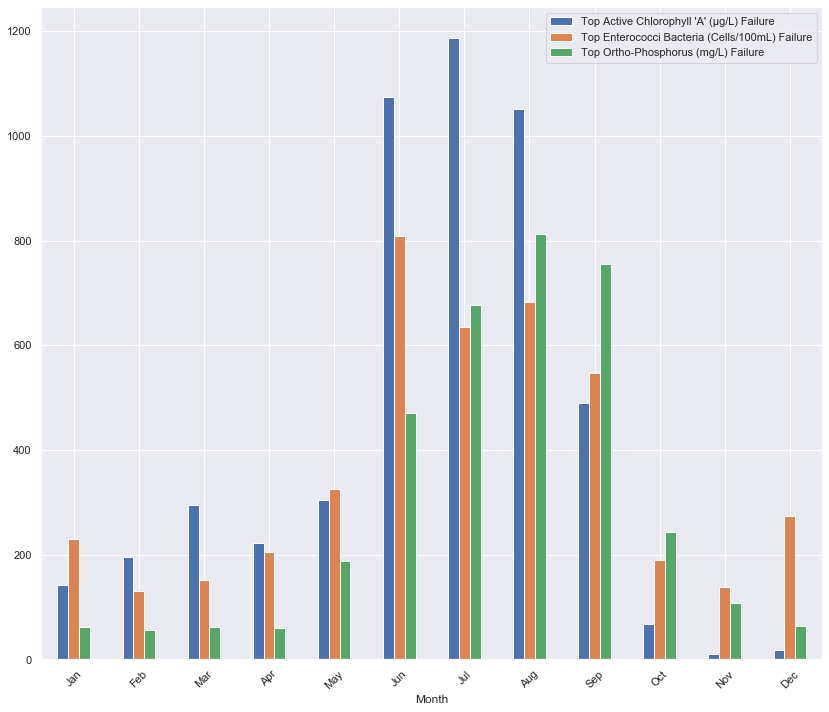

In [32]:
_ = pivot.plot(kind='bar', figsize=(14, 12))
_ = plt.xticks(np.arange(0, 12), 
           labels=['Jan', 'Feb', 'Mar', 'Apr',
                   'May', 'Jun', 'Jul', 'Aug',
                   'Sep', 'Oct', 'Nov', 'Dec'],
           rotation=45)
_ = plt.show()

I want to compare sites with high failure proportions with low proportions. I will look at E2 and NC0. These are two sites that are relatively close to each other but have much different measurements.

In [33]:
nc0 = final_df[final_df['Sampling Location'] == 'NC0']
e2 = final_df[final_df['Sampling Location'] == 'E2']

In [34]:
nc0.loc[:, fail_col].sum()

Top Ammonium (mg/L) Failure                                                             18
Top Active Chlorophyll 'A' (µg/L) Failure                                              156
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure    159
Top Enterococci Bacteria (Cells/100mL) Failure                                         211
Top Fecal Coliform Bacteria (Cells/100mL) Failure                                      129
Top Total Kjeldhal Nitrogen (mg/L) Failure                                               0
Top PH Failure                                                                           1
Top Ortho-Phosphorus (mg/L) Failure                                                    144
dtype: int64

In [35]:
e2.loc[:, fail_col].sum()

Top Ammonium (mg/L) Failure                                                             0
Top Active Chlorophyll 'A' (µg/L) Failure                                               1
CTD (conductivity, temperature, depth profiler) Top Dissolved Oxygen (mg/L) Failure    32
Top Enterococci Bacteria (Cells/100mL) Failure                                         30
Top Fecal Coliform Bacteria (Cells/100mL) Failure                                       1
Top Total Kjeldhal Nitrogen (mg/L) Failure                                              0
Top PH Failure                                                                          0
Top Ortho-Phosphorus (mg/L) Failure                                                     6
dtype: int64